# Data Understanding

In [50]:
import pandas
import matplotlib.pyplot as pyplot
import numpy
import seaborn

# Read in the data and display the first 5 columns
dataframe = pandas.read_csv('./calendar.csv')

# Set the date column to be a pandas datetime column
dataframe['date'] = pandas.to_datetime(dataframe['date'])

# Set the price column to be a float
dataframe['price'] = dataframe['price'].str.replace('[\$,]', '', regex=True).astype(float)

dataframe.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


To check the price delta between various times of year and between available and unavailable listings...clear up any NaN values for price

# Prepare Data

In [51]:
# Check if there are any null values in the available or date columns
nullPrices = dataframe['price'].isnull().sum()

notNullPrices = dataframe['price'].value_counts().sum()

nullPrices, notNullPrices

(459028, 934542)

There are 459,028 rows without a price, and 934,542 rows with a price. Check to see if all the rows without a price are rows that are not available

In [52]:
nullPrices = dataframe.loc[dataframe['available'] == 'f']['price'].isnull().sum()

nullPrices

459028

The rows with unavailable listings do not list a price. What are some options for imputing the missing values? Get a list of available listings and prices

In [53]:
availableListings = dataframe.loc[dataframe['available'] == 't'].copy()

availableListings = availableListings[['listing_id', 'price']].groupby(['listing_id', 'price'], as_index=False)

availableListings = availableListings.mean().groupby('listing_id')['price'].mean().round(2)

availableListings = pandas.DataFrame(availableListings.reset_index())

availableListings

,listing_id,price
0,3335,120.00
1,4291,82.00
2,5682,52.50
3,6606,95.00
4,7369,85.00
...,...,...
3718,10331249,45.00
3719,10332096,40.00
3720,10334184,120.00
3721,10339145,262.33


An option would be to take these means values for available listings and fill all nan fields with their respective mean price based on the listing

In [54]:
def find_available_listings_mean(row):
    """
        INPUT
        row - pandas.core.series.Series

        OUTPUT
        X - A matrix holding all of the variables you want to consider when predicting the response
        y - the corresponding response vector

        This function searches for the listing id of available listings and returns the price
        1. If the price column in the row is null
        2. Search for the listing id in the available listings frame
        3. Get the price
    """
    if numpy.isnan(row['price']):
        try:
            price = availableListings.loc[availableListings['listing_id'] == row['listing_id']]['price'].item()

            return price
        except:
            return row['price']
    else:
        return row['price']

dataframe['price'] = dataframe.apply(
    lambda row: find_available_listings_mean(row),
    axis=1
)

In [56]:
def slice_by_availability(_dataframe, availability):
    '''
    INPUT
    df - pandas dataframe
    availability - string

    OUTPUT
    listings - Pandas series

    This function get the listings by availability and year:
    1. Get the listings by availability
    2. Add a year and month column to the dataframe
    3. Filter out listings not in 2016
    4. Return the dataframe
    '''
    listings = _dataframe.loc[_dataframe['available'] == availability].copy()

    listings['month'] = pandas.to_datetime(listings['date']).dt.month
    listings['year'] = pandas.to_datetime(listings['date']).dt.year

    listings = listings.loc[listings['year'] == 2016].copy()

    return listings

# Model Data
Putting it all together, graph a point plot with one set being the pricing per month for available listings, and the other unavailable listings

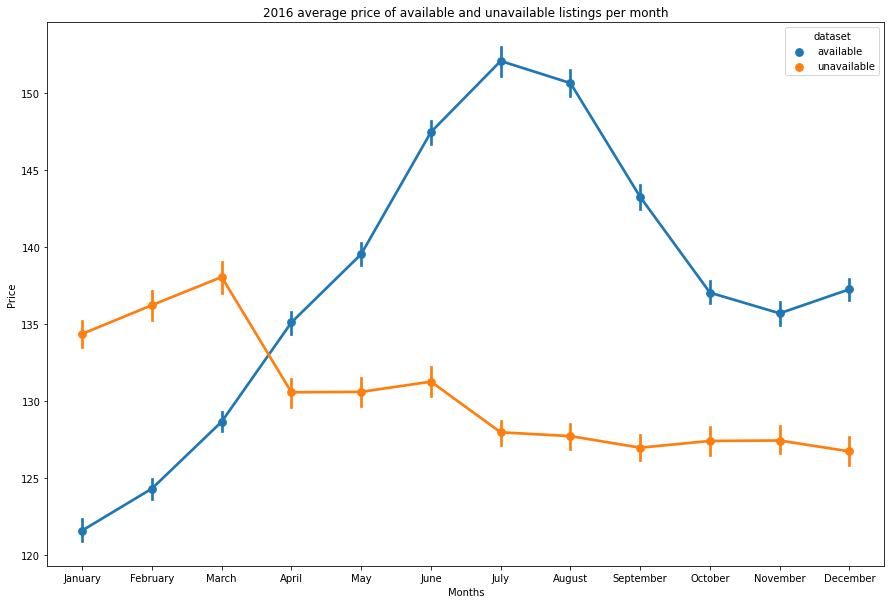

In [57]:
# Plot a bar graph detailing average price per month
available_listings = slice_by_availability(dataframe, 't')
unavailable_listings = slice_by_availability(dataframe, 'f')

plot_data = pandas.concat([available_listings.assign(dataset='available'), unavailable_listings.assign(dataset='unavailable')])

plot_data = plot_data[['month', 'dataset', 'price']]

plot_data['month'] = plot_data['month'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

pyplot.subplots(figsize = (15,10))
seaborn.pointplot(x = 'month', y = 'price', hue='dataset', data=plot_data)
pyplot.ylabel('Price')
pyplot.xlabel('Months')
pyplot.title('2016 average price of available and unavailable listings per month')

pyplot.savefig('available_listings_vs_unavailable_listings_price_2016.png')

# Evaluation
By imputing the average price for an available listing onto the NaN values for unavailable listings it's clear there's at least some correlation between price and availability. However, the imputation is limited by a number of factors. For example, a price might be higher due to higher demand which would be missing from the mean.